In [8]:
import os
import cv2
import numpy as np
from PIL import Image  # Use PIL for TIFF images
import matplotlib.pyplot as plt
from sklearn.utils import shuffle #Shuffles the dataset to avoid bias in deep learning models.


# Define Dataset Paths

In [2]:
PARASITIZED = "/home/joshua/Project/DL/Malaria/Parasitized"
UNINFECTED = "/home/joshua/Project/DL/Malaria/Uninfected"


🔍 Searching for images in: /home/joshua/Project/DL/Malaria/Parasitized


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


✅ Loaded 1896 images from /home/joshua/Project/DL/Malaria/Parasitized. Shape: (1896, 128, 128)
🔍 Searching for images in: /home/joshua/Project/DL/Malaria/Uninfected
✅ Loaded 1170 images from /home/joshua/Project/DL/Malaria/Uninfected. Shape: (1170, 128, 128)


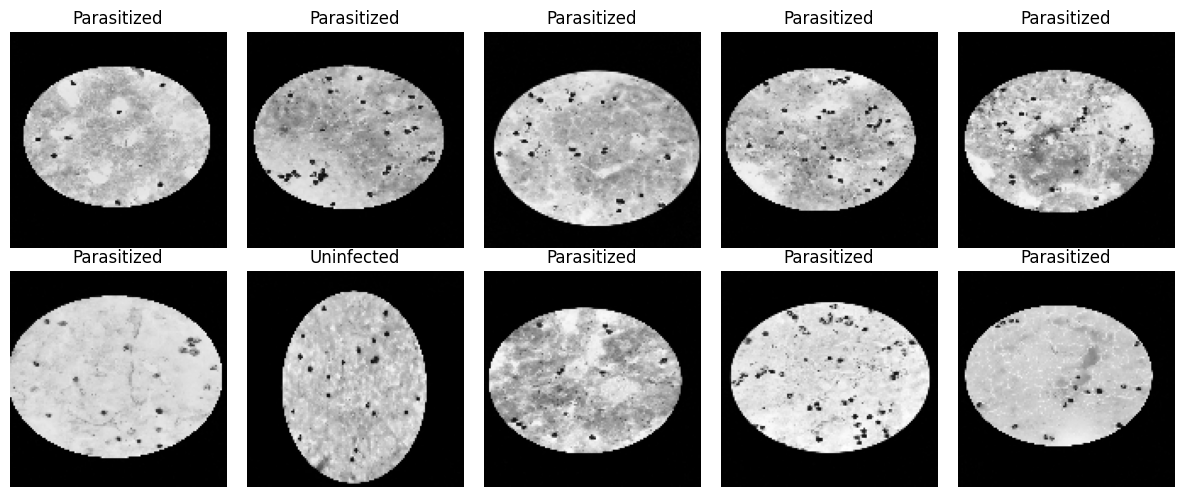

In [3]:

# Load images function (recursively from deeply nested subfolders)
def load_images(folder, label, sample_size=None, grayscale=True):
    images, labels = [], []
    print(f"🔍 Searching for images in: {folder}")  

    for root, _, files in os.walk(folder):  # Walk through all levels of subdirectories
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):  
                continue
            
            img_path = os.path.join(root, file)
            img = None

            try:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
                elif file.lower().endswith('.tiff'):
                    img = Image.open(img_path).convert("L" if grayscale else "RGB")  
                    img = np.array(img)
                    if not grayscale:
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  

                if img is None:
                    print(f"⚠️ Warning: Unable to read {img_path}")  # Debug print
                    continue  

                img = cv2.resize(img, (128, 128))  # Resize for uniformity
                images.append(img)
                labels.append(label)

                if sample_size and len(images) >= sample_size:
                    print(f"✅ Loaded {len(images)} images from {folder} (early stop)")
                    return np.array(images), np.array(labels)

            except Exception as e:
                print(f"❌ Error loading {img_path}: {e}")
                continue  

    print(f"✅ Loaded {len(images)} images from {folder}. Shape: {np.array(images).shape}")  
    return np.array(images), np.array(labels)

# Load datasets from all subfolders
parasite_images, parasite_labels = load_images(PARASITIZED, 1, grayscale=True)
uninfected_images, uninfected_labels = load_images(UNINFECTED, 0, grayscale=True)

# 🛑 **Check if both datasets contain images**
if parasite_images.size == 0 and uninfected_images.size == 0:
    print("❌ Error: No images loaded from both datasets! Check the folder paths.")
    exit()
elif parasite_images.size == 0:
    print("⚠️ Warning: No images found in PARASITIZED dataset.")
elif uninfected_images.size == 0:
    print("⚠️ Warning: No images found in UNINFECTED dataset.")

# **Concatenate datasets only if they contain images**
if parasite_images.size > 0 and uninfected_images.size > 0:
    images = np.concatenate((parasite_images, uninfected_images), axis=0)
    labels = np.concatenate((parasite_labels, uninfected_labels), axis=0)
elif parasite_images.size > 0:  
    images, labels = parasite_images, parasite_labels
elif uninfected_images.size > 0:  
    images, labels = uninfected_images, uninfected_labels
else:
    print("❌ Error: No images available to process.")
    exit()

# Shuffle the dataset
images, labels = shuffle(images, labels, random_state=42)

# Visualize some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.set_title("Parasitized" if labels[i] == 1 else "Uninfected")
    ax.axis("off")

plt.tight_layout()
plt.show()

    
    


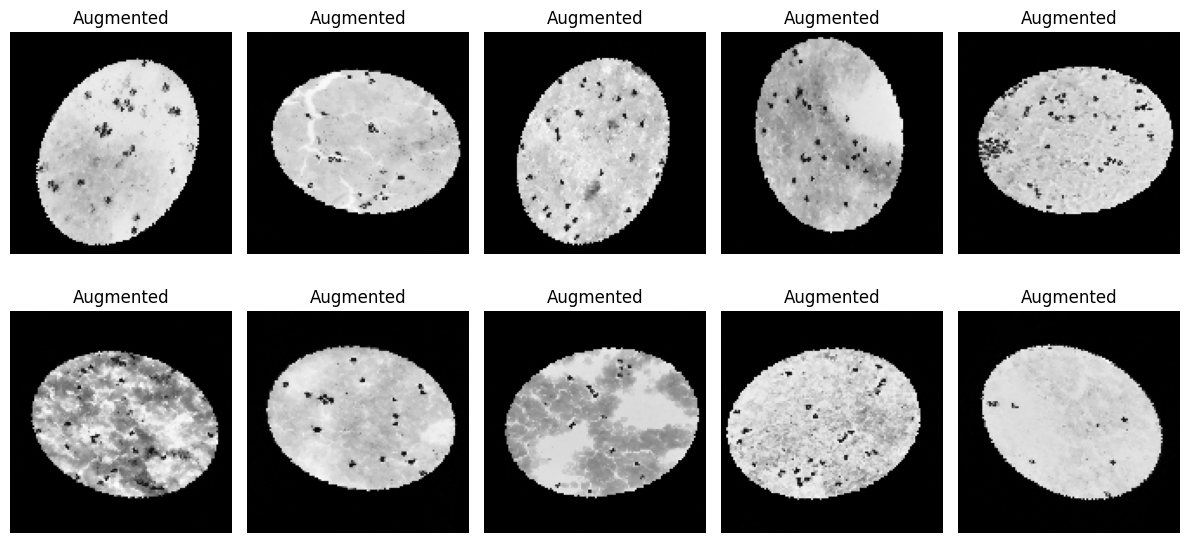

In [7]:
import torchvision.transforms as transforms
from PIL import Image
import random

# Define augmentation transformations
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(images) - 1)
    img_pil = Image.fromarray(images[idx])  # Convert to PIL image
    img_aug = transform(img_pil)  # Apply augmentation
    ax.imshow(img_aug, cmap="gray")
    ax.set_title("Augmented")
    ax.axis("off")

plt.tight_layout()
plt.show()


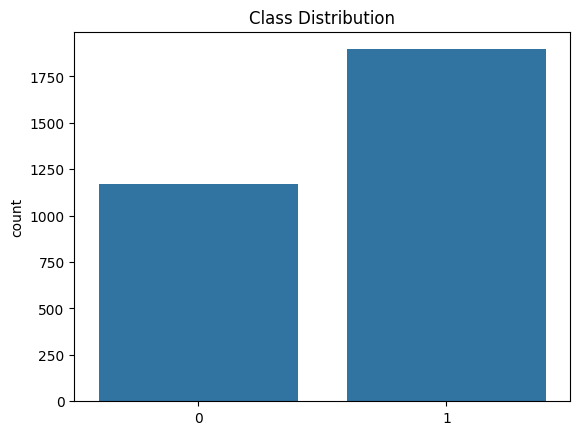

In [4]:
# Data Distribution
import seaborn as sns
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.show()

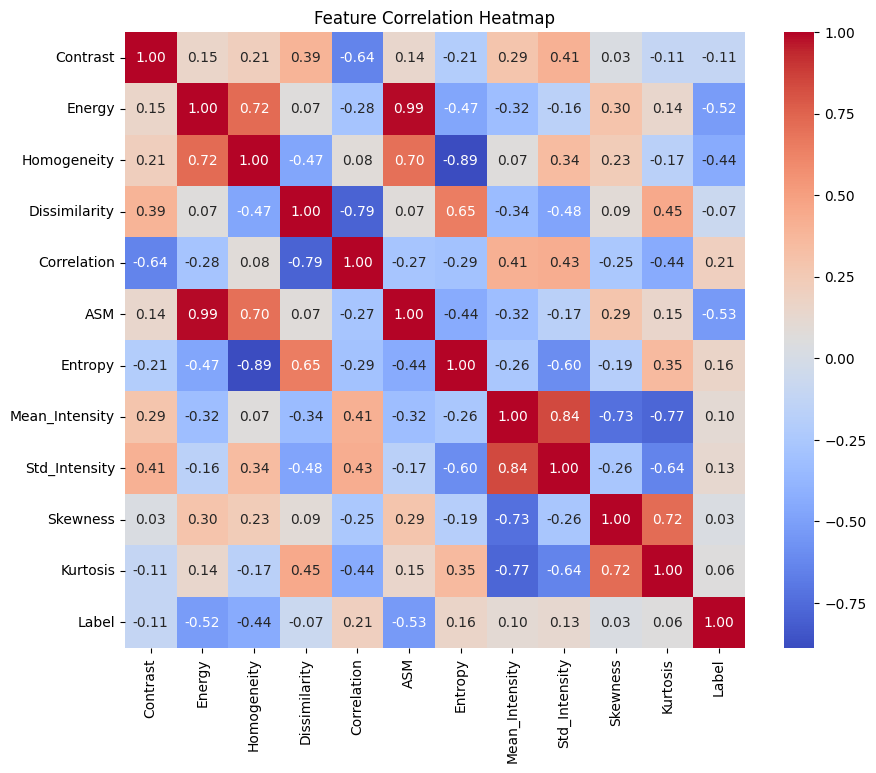

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

# Extended Texture Feature Extraction
def extract_texture_features(image):
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    distances = [1]

    glcm = graycomatrix(image, distances, angles, symmetric=True, normed=True)

    contrast = np.mean(graycoprops(glcm, 'contrast'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    asm = np.mean(graycoprops(glcm, 'ASM'))

    # Entropy Calculation
    glcm_prob = glcm / np.sum(glcm)  # Normalize GLCM
    entropy = -np.sum(glcm_prob * np.log2(glcm_prob + 1e-10))  # Avoid log(0)

    # Statistical Features
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())

    return [contrast, energy, homogeneity, dissimilarity, correlation, asm, entropy, mean_intensity, std_intensity, skewness, kurt]

# Compute features for all images
features = [extract_texture_features(img) for img in images]
df_features = pd.DataFrame(features, columns=["Contrast", "Energy", "Homogeneity", "Dissimilarity", "Correlation", "ASM", "Entropy", "Mean_Intensity", "Std_Intensity", "Skewness", "Kurtosis"])
df_features["Label"] = labels  

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


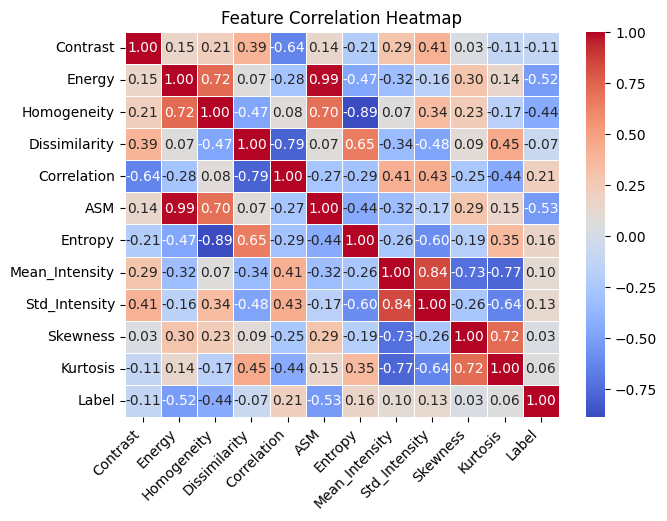

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

# Extended Texture Feature Extraction
def extract_texture_features(image):
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    distances = [1]

    glcm = graycomatrix(image, distances, angles, symmetric=True, normed=True)

    contrast = np.nan_to_num(np.mean(graycoprops(glcm, 'contrast')))
    energy = np.nan_to_num(np.mean(graycoprops(glcm, 'energy')))
    homogeneity = np.nan_to_num(np.mean(graycoprops(glcm, 'homogeneity')))
    dissimilarity = np.nan_to_num(np.mean(graycoprops(glcm, 'dissimilarity')))
    correlation = np.nan_to_num(np.mean(graycoprops(glcm, 'correlation')))
    asm = np.nan_to_num(np.mean(graycoprops(glcm, 'ASM')))

    # Entropy Calculation
    glcm_prob = glcm / (np.sum(glcm) + 1e-10)  # Avoid division by zero
    entropy = -np.sum(glcm_prob * np.log2(glcm_prob + 1e-10))  # Avoid log(0)

    # Statistical Features
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())

    return [contrast, energy, homogeneity, dissimilarity, correlation, asm, entropy, mean_intensity, std_intensity, skewness, kurt]

features = [extract_texture_features(img) for img in images]
df_features = pd.DataFrame(features, columns=["Contrast", "Energy", "Homogeneity", "Dissimilarity", "Correlation", "ASM", "Entropy", "Mean_Intensity", "Std_Intensity", "Skewness", "Kurtosis"])
df_features["Label"] = labels  

# Correlation heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(df_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Correlation Heatmap")
plt.show()


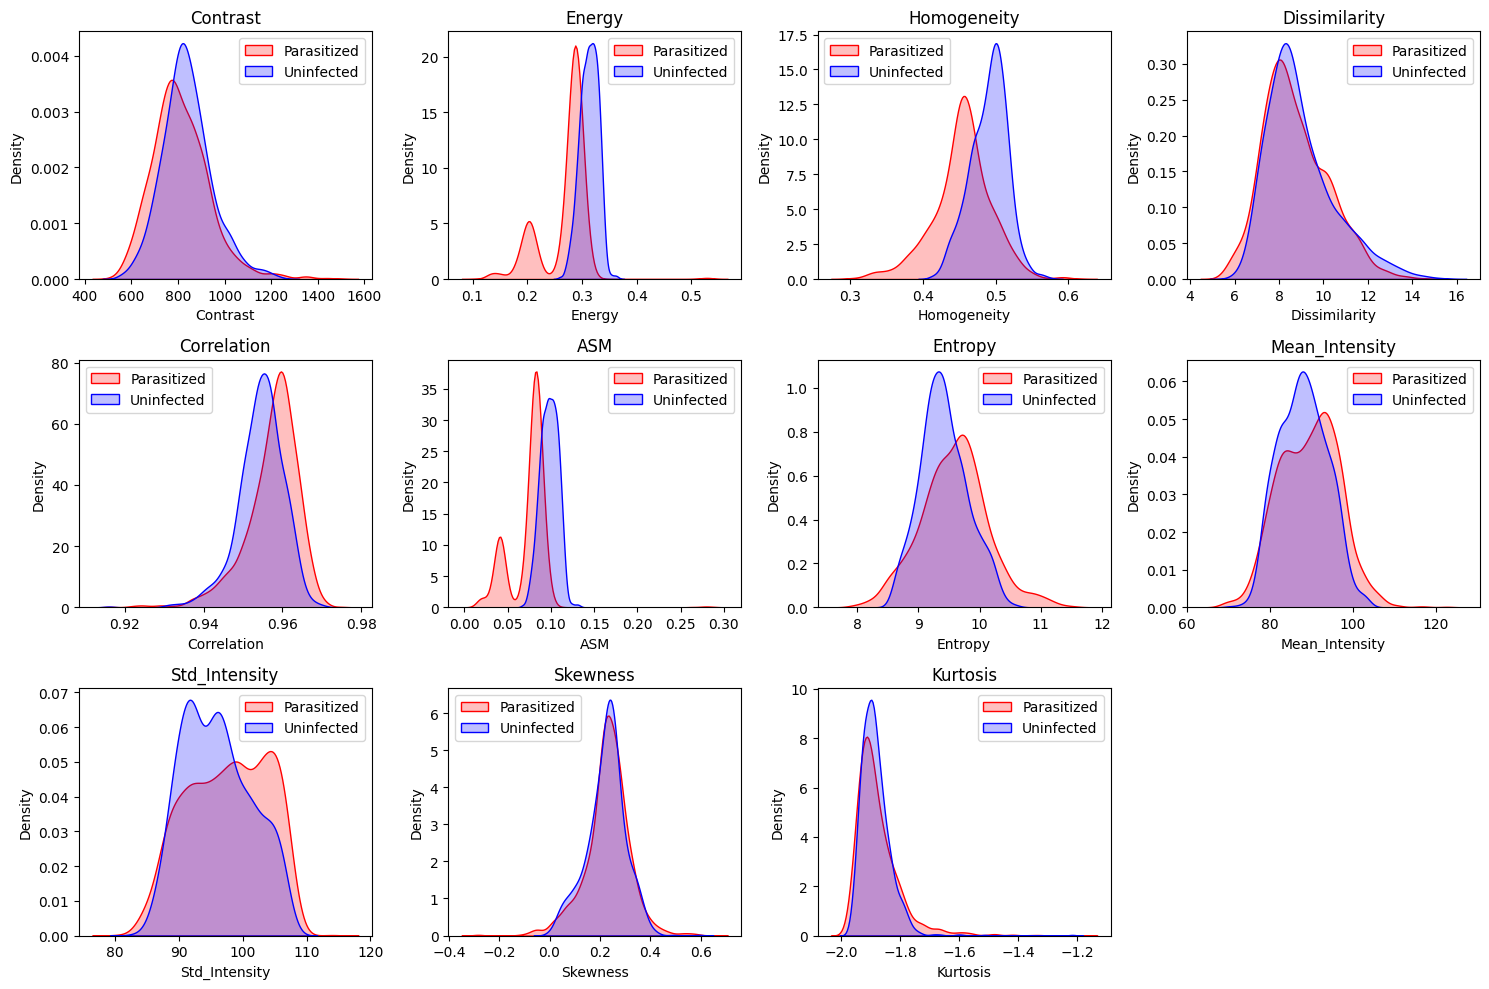

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution for each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_features.columns[:-1]):  # Exclude 'Label'
    plt.subplot(3, 4, i + 1)
    sns.kdeplot(df_features[df_features["Label"] == 1][column], label="Parasitized", fill=True, color="r")
    sns.kdeplot(df_features[df_features["Label"] == 0][column], label="Uninfected", fill=True, color="b")

    plt.title(column)
    plt.legend()
plt.tight_layout()
plt.show()


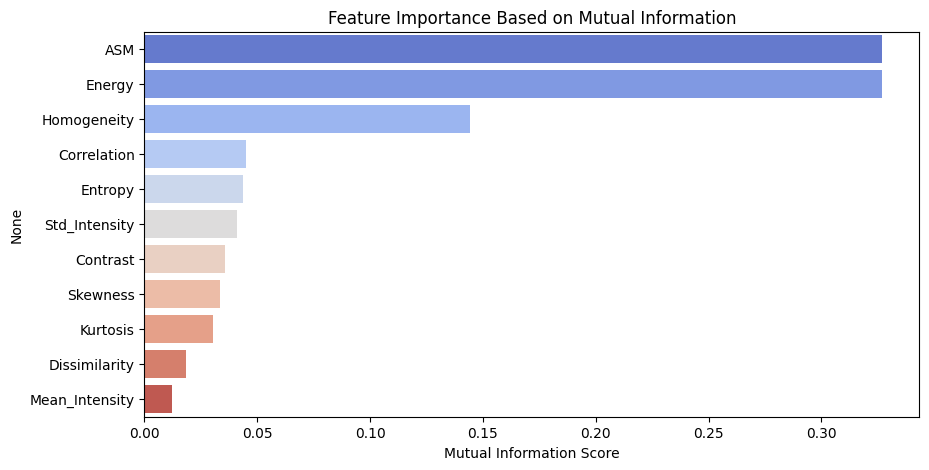

In [15]:
from sklearn.feature_selection import mutual_info_classif

X = df_features.drop(columns=["Label"])
y = df_features["Label"]

mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=mi_series, y=mi_series.index, hue=mi_series.index, palette="coolwarm", legend=False)

plt.xlabel("Mutual Information Score")
plt.title("Feature Importance Based on Mutual Information")
plt.show()


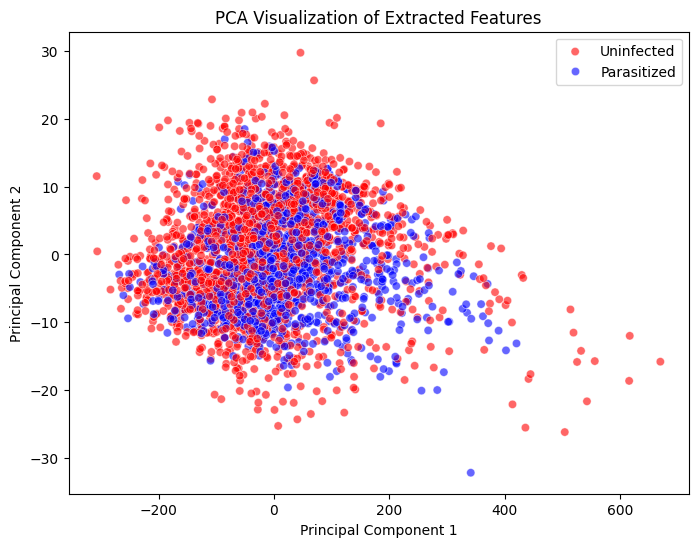

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["blue", "red"], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Extracted Features")
plt.legend(["Uninfected", "Parasitized"])
plt.show()


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["blue", "red"], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization (Standardized Data)")
plt.legend(["Uninfected", "Parasitized"])
plt.show()


NameError: name 'X' is not defined

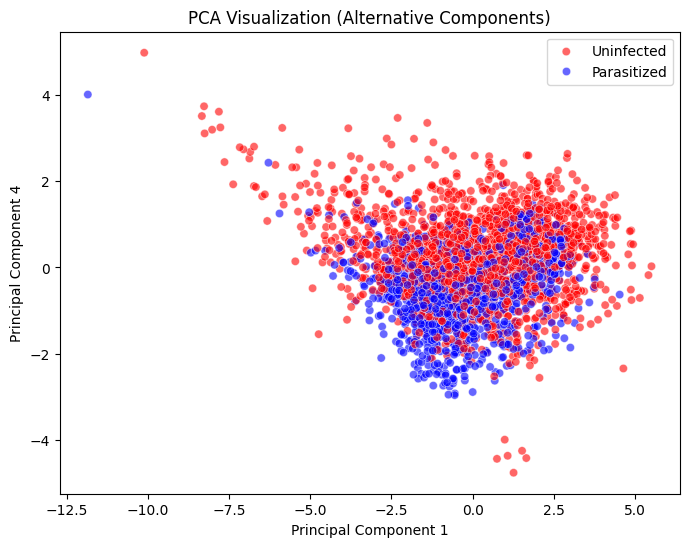

In [21]:
pca = PCA(n_components=11)  # Use max possible components
X_pca_full = pca.fit_transform(X_scaled)

# Now select two different components
X_pca = X_pca_full[:, [0, 3]]  # Example: 1st and 4th components

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["blue", "red"], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 4")
plt.title("PCA Visualization (Alternative Components)")
plt.legend(["Uninfected", "Parasitized"])
plt.show()


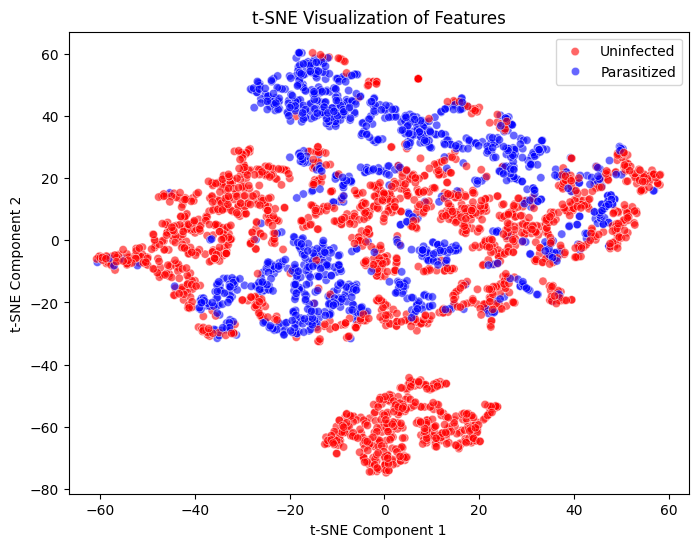

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette=["blue", "red"], alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Features")
plt.legend(["Uninfected", "Parasitized"])
plt.show()


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y, palette=["blue", "red"], alpha=0.6)
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("LDA Visualization of Features")
plt.legend(["Uninfected", "Parasitized"])
plt.show()


NameError: name 'X_scaled' is not defined